# Object recognition by matching features points

The objective of this lab is to develop an object recognition program based on the matching of feature points extarcted from images.

**Extraction of feature points**

In this phase, we will extract feature points such as SIFT (Scale-Invariant Feature Transform) from a set of reference images and store them in the form of a suitable data structure. The SIFT descriptor and others are already implemented in opencv in the cv2.xfeatures2d package.

Since corners are interesting features of an image. Feature detection algorithms started by detecting corners. There are a number of techniques in OpenCV to detect features. Here are the most popular feature detectors:

* Haris corner detection
* Shi-Tomasi corner detection
* SIFT (Scale-Invariant Feature Transform)
* SURF (Speeded-Up Robust Features)
* FAST algorithm for corner detection
* ORB (Oriented FAST and Rotated Brief)

**SIFT (Scale-Invariant Feature Transform):**

SIFT is both rotation and scale invariant. It provides keypoints and keypoint descriptors where the keypoint descriptor describes the keypoint at a selected scale and rotation with image gradients. We display SIFT with circles representing key points/features, where the size of the circle represents the strength of the key point and the line inside the circle indicates the orientation of the key point.

SIFT is patented and not freely available for commercial use. It requires opencv-contrib to be installed in order to use them

In [1]:
# monter votre Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale Lille/G3/Data_feature_extraction.zip"

with ZipFile(file_name, 'r') as zip_:
  zip_.extractall()
  print('Done')

Done


In [3]:
!pip install -U opencv-python

Images can be daownloded here:
https://drive.google.com/file/d/1utzjL4tOpeS9yWmBEw9tUuzsq1NXZw2M/view?usp=sharing

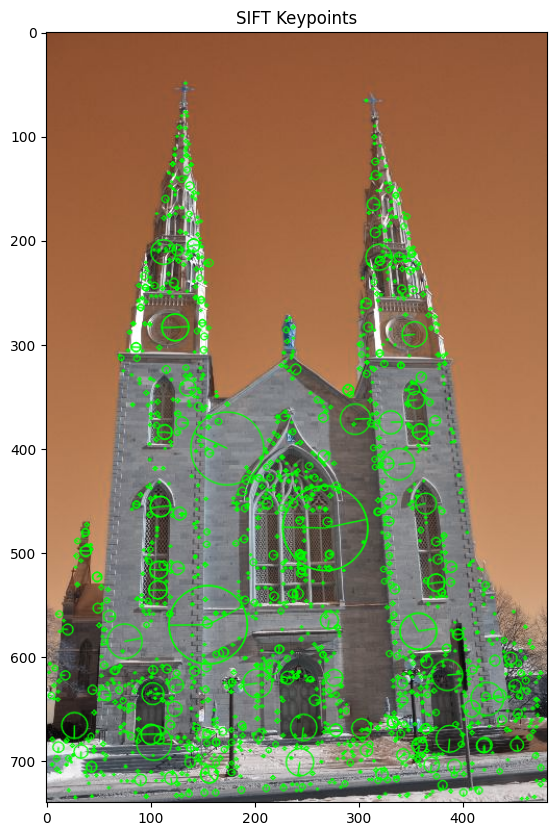

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Data/church01.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp, desc = feature_extractor.detectAndCompute(gray_img, None)

kp_img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0),  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

figsize = (10, 10)
plt.figure(figsize=figsize)
plt.imshow(kp_img)
plt.title("SIFT Keypoints")
plt.show()

**Feature matching** :
Matching features between images can be done with:

* Brute-Force (BF) Matcher: it matches the descriptor of a feature of an image with all the other features of another image and returns the match according to the distance. It is slow because it checks the correspondence with all the characteristics.
* Flannmatcher: Fast Library for Fuzzy Nearest Neighbors (FLANN) is optimized to find matches with search even with large datasets, hence its speed compared to Brute-Force matcher.

First, load an image "image", initialize the SIFT detector and then calculate the feature points and the corresponding descriptors:

In [5]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2

rgb_l = cv2.cvtColor(cv2.imread("Data/church01.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("Data/church02.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

In [6]:
#feature_extractor = cv2.xfeatures2d.SIFT_create()
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

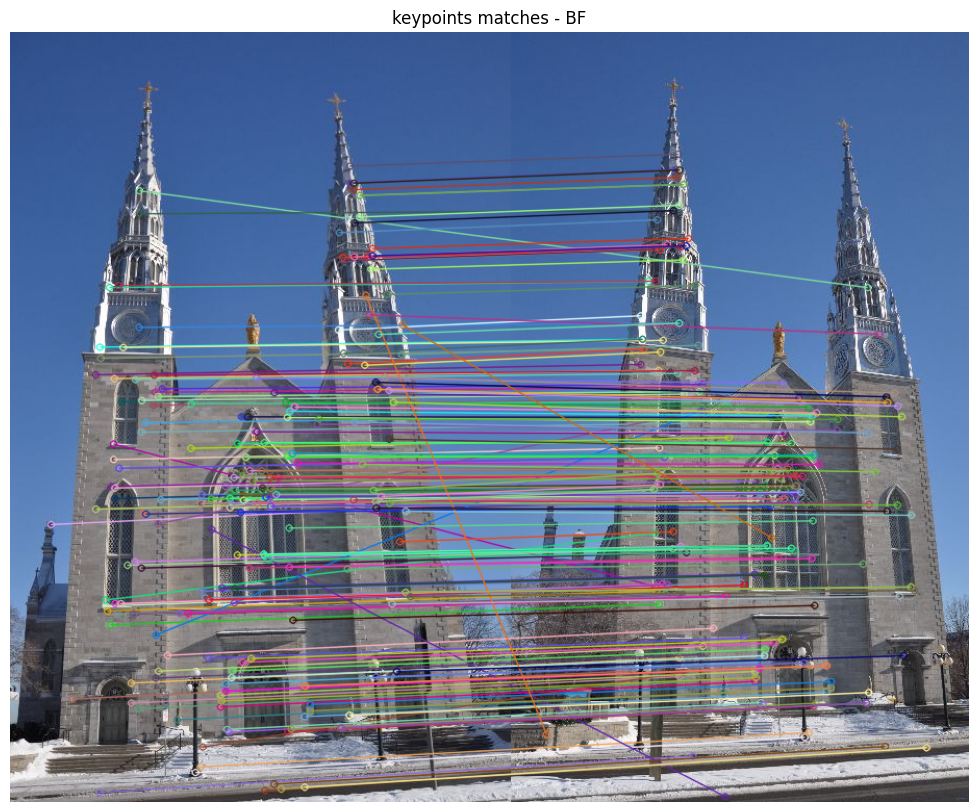

(<matplotlib.image.AxesImage at 0x7cff1b13ae00>, None)

In [7]:
#Brute-Force (BF) Matcher:

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# store all the good matches as per Lowe's ratio test.
good_match = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_match.append(m)

src_pts = np.float32([ kp_l[m.queryIdx].pt for m in good_match ]).reshape(-1, 2)
dst_pts = np.float32([ kp_r[m.trainIdx].pt for m in good_match ]).reshape(-1, 2)

matches = cv2.drawMatches(rgb_l,kp_l,rgb_r,kp_r, good_match,None, flags=2)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title("keypoints matches - BF")
plt.imshow(matches),plt.show()

Many of the correspondences are faulty and simply estimating the parameter set with all coordinates is not sufficient. Therefore, the RANSAC (RANdom Sample Consensus) algorithm is used on top of the normal model to robustly estimate the parameter set by detecting outliers.

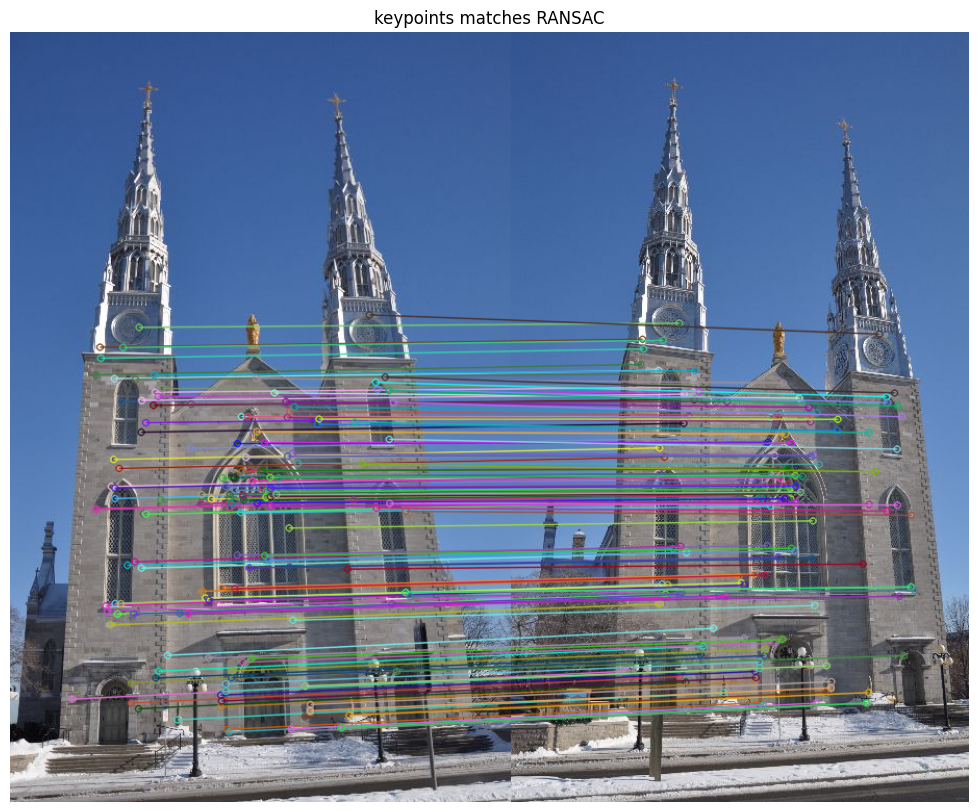

(<matplotlib.image.AxesImage at 0x7cff14c49480>, None)

In [8]:
# Ransac

from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform

model, inliers = ransac(
        (src_pts, dst_pts),
        AffineTransform, min_samples=4,
        residual_threshold=8, max_trials=10000
    )

n_inliers = np.sum(inliers)

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
#image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None)

#plt.imshow(image3)

matches_ran = cv2.drawMatches(rgb_l,inlier_keypoints_left,rgb_r,inlier_keypoints_right, placeholder_matches,None, flags=2)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title("keypoints matches RANSAC")
plt.imshow(matches_ran),plt.show()


**Image clssification/retrieval by visual content (Bag of Visual Words)**

Bag of visual words or Bag of features (BoF) is one of the most used approaches for the classification and retrieval of visual data. It is inspired by a concept called Bag of Words used in document classification. A bag of words is a simple word count vector; that is, a sparse histogram on the vocabulary. In computer vision, an entity sight word packet is a simple occurrence count vector of a local entity vocabulary.

The objective of the lab is to develop an image search system by visual content that is efficient for large image collections. Conventionally, a system for searching for images by visual content comprises an off-line phase for indexing the image database and an on-line search phase proper.
We start with a classification process and we will see how to transform it into a content search system (search engine). The classification process consists of two main phases:

1. Learning phase: this phase consists of calculating SIFT descriptors

(Scale-Invariant Feature Transform) from a set of reference images and store them as a convenient data structure for easy reuse.


In [9]:
# Importer les packages nécessaires :

import argparse as ap
import cv2
import imutils
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.svm import LinearSVC

from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors

from sklearn import preprocessing

Download the image data (dataset-classif.zip:
https://drive.google.com/file/d/1YLcCKCNFNRqTqjIKObwTzsb4GAVLNLFK/view?usp=sharing

Provide the path to the learning data in your code, and parse the data folders to organize the class labels.

In [33]:
# monter votre Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale Lille/G3/Data-BoW.zip"

with ZipFile(file_name, 'r') as zip_:
  zip_.extractall()
  print('Done')

Done


In [12]:
# Get the path of the training set
train_path = './Data-BoW/dataset-classif/train/'
# Get the training classes names and store them in a list
training_names = os.listdir(train_path)

def imlist(path):
    """
    The function imlist returns all the names of the files in
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths += class_path
    image_classes += [class_id] * len(class_path)
    class_id += 1

Start by extracting the SIFT points in all the images. Then store the descriptors around these points in a list.

In [13]:
# Create feature extraction and keypoint detector objects
des_list = []

sift = cv2.SIFT_create()

for image_path in image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    des_list.append((image_path, des))

Stack all descriptors into a numpy array

In [14]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

Now, apply clustering to create a vocabulary of (here 100) visual words
k = 100
voc, variance = kmeans(descriptors, k, 1)

Then, calculate the histograms of the features, using vector quantization which allows us to create our vocabulary of visual words.

In [15]:
# Perform k-means clustering
k = 100
print ("Start k-means: %d words, %d key points" % (k, descriptors.shape[0]))

voc, variance = kmeans(descriptors, k, 1)

# Calculate the histogram of features
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        im_features[i][w] += 1

Start k-means: 100 words, 11799 key points


In [16]:
#transform vector
nbr_occurences = np.sum((im_features>0)*1,axis=0)
idf = np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_occurences+1)),'float32')
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

With the histograms obtained for each class, we can train a classifier (knn, svm, …)

In [17]:
kn = 5
# Train the Linear SVM
clf = LinearSVC()
#clf = neighbors.KNeighborsClassifier()
#clf = neighbors.KNeighborsClassifier(kn,weights='uniform',p=2,metric='minkowski')
clf.fit(im_features, np.array(image_classes))

LinearSVC()

You can save the model resulting from the training, which contains the classifier, the class names, the transformation vector, the number of clusters and the vocabulary. This makes it possible to separate the two phases, learning and testing.

In [18]:
#from sklearn.externals import joblib
#!pip install joblib

In [19]:
# Save the model
import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "bof_class.pkl", compress=3)

['bof_class.pkl']

2- In the test phase, the following steps must be applied:

load the model,
load the test images (as for the training)
calculate SIFT descriptors in test images (as for the training)
apply the prediction function to predict the class of each test image.

In [20]:
# chargement du modèle:
clf, classes_names, stdSlr, k, voc = joblib.load("bof_class.pkl")

In [21]:
image_paths = []
test_path = './Data-BoW/dataset-classif/test/'
testing_names = os.listdir(test_path)
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imlist(dir)
    image_paths += class_path

In [22]:
# chargement des images de teste
sift = cv2.SIFT_create()

# List où les descripeturs seront stoqués
des_list = []
# calcul des descripteurs SIFT
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    des_list.append((image_path, des))

# Empilez tous les descripteurs verticalement dans un tableau numpy
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor))

#
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        test_features[i][w] += 1

In [23]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum((test_features > 0) * 1, axis=0)
idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

In [24]:
# Scale the features
test_features = stdSlr.transform(test_features)

# Perform the predictions
predictions = [classes_names[i] for i in clf.predict(test_features)]

In [25]:
# Visualiser les résultats si le flag "visualize" est défini comme True
visualize = True

if visualize:
    for image_path, prediction in zip(image_paths, predictions):
        # Lire l'image
        image = cv2.imread(image_path)

        # Convertir l'image de BGR à RGB pour l'affichage avec matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Ajouter du texte sur l'image
        pt = (0, 3 * image.shape[0] // 4)  # Position du texte
        cv2.putText(image_rgb, prediction, pt, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

        # Afficher l'image avec matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off')  # Masquer les axes
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Exercice 1:**

Now, transform your classifier into a search engine that calculates a similarity score instead of predicting a label. In other words, it is the search by visual similarity from an example. In its simplest form, the system receives as input an example image (query) and returns the set of images most similar to this image, in the sense of the similarity measure associated with the signature (here the histogram calculated at from the visual vocabulary). The search involves finding the nearest neighbors of the signature associated with the query image. In this case, instead of learning a learning model, you should use a distance instead:

Use for this part of the lab the 'dataset-retr'

In [65]:
# Load the test images (you can adjust the test set based on your dataset)
train_path = './Data-BoW/dataset-retr/train/'
# Get a list of all files and subdirectories in the train_path
training_names = os.listdir(train_path)

train_image_paths = []
for training_name in training_names:
    # Create the full path to the file/directory
    item_path = os.path.join(train_path, training_name)

    # Check if the item is a file and if it's an image
    if os.path.isfile(item_path) and training_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        train_image_paths.append(item_path)  # Add image paths to the list

In [66]:
# Create feature extraction and keypoint detector objects
des_list = []

sift = cv2.SIFT_create()

for image_path in train_image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    des_list.append((image_path, des))

In [67]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

In [71]:
# Perform k-means clustering
k = 700
print ("Start k-means: %d words, %d key points" % (k, descriptors.shape[0]))

voc, variance = kmeans(descriptors, k, 1)

# Calculate the histogram of features
im_features = np.zeros((len(train_image_paths), k), "float32")
for i in range(len(train_image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        im_features[i][w] += 1

Start k-means: 700 words, 107245 key points


In [72]:
#transform vector
nbr_occurences = np.sum((im_features>0)*1,axis=0)
idf = np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_occurences+1)),'float32')
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [74]:
# Save the model
import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "bof_class_retr.pkl", compress=3)

['bof_class_retr.pkl']

___

In [75]:
# Load the pre-trained model (classifier, classes, vocabulary, etc.)
clf, classes_names, stdSlr, k, voc = joblib.load("bof_class_retr.pkl")

# Define the function to compute the SIFT descriptors and feature histograms
def compute_feature_histograms(image_paths, voc, sift, k):
    des_list = []
    for image_path in image_paths:
        im = cv2.imread(image_path)
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        des_list.append((image_path, des))

    # Stack all descriptors vertically in a numpy array
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))

    # Create feature histograms for all images
    features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum((features > 0) * 1, axis=0)
    idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

    # Apply the transformation
    features = stdSlr.transform(features)
    return features

In [76]:
# Function to calculate the similarity score (Euclidean distance)
def search_similar_images(query_image_path, image_paths, voc, sift, stdSlr, k, top_n=5):
    # Compute the feature histogram for the query image
    query_image = cv2.imread(query_image_path)
    gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)

    # Create a feature histogram for the query image
    query_histogram = np.zeros((1, k), "float32")
    words, distance = vq(des, voc)
    for w in words:
        query_histogram[0][w] += 1

    # Perform Tf-Idf vectorization for the query
    nbr_occurences = np.sum((query_histogram > 0) * 1, axis=0)
    idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')
    query_histogram = query_histogram * idf

    # Apply the transformation for the query image
    query_histogram = stdSlr.transform(query_histogram)

    # Compute the Euclidean distances between the query histogram and the feature histograms of all images
    distances = np.linalg.norm(query_histogram - image_features, axis=1)

    # Sort the images by distance (ascending order), so the smallest distance is first
    sorted_indices = np.argsort(distances)

    # Get the most similar images (top_n)
    similar_images = [(image_paths[i], distances[i]) for i in sorted_indices[:top_n]]

    return similar_images

Rank 1: ./Data-BoW/dataset-retr/train/ukbench00038.jpg with similarity score (distance): 29.72435188293457
Rank 2: ./Data-BoW/dataset-retr/train/ukbench00039.jpg with similarity score (distance): 32.502784729003906
Rank 3: ./Data-BoW/dataset-retr/train/ukbench00036.jpg with similarity score (distance): 33.94077682495117
Rank 4: ./Data-BoW/dataset-retr/train/ukbench00037.jpg with similarity score (distance): 34.02277755737305
Rank 5: ./Data-BoW/dataset-retr/train/ukbench00048.jpg with similarity score (distance): 36.52728271484375
Rank 6: ./Data-BoW/dataset-retr/train/ukbench00019.jpg with similarity score (distance): 36.74341583251953


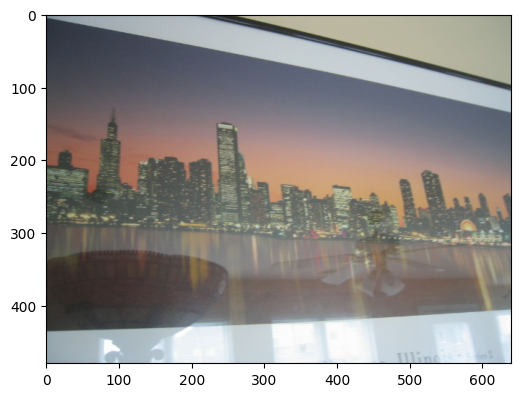

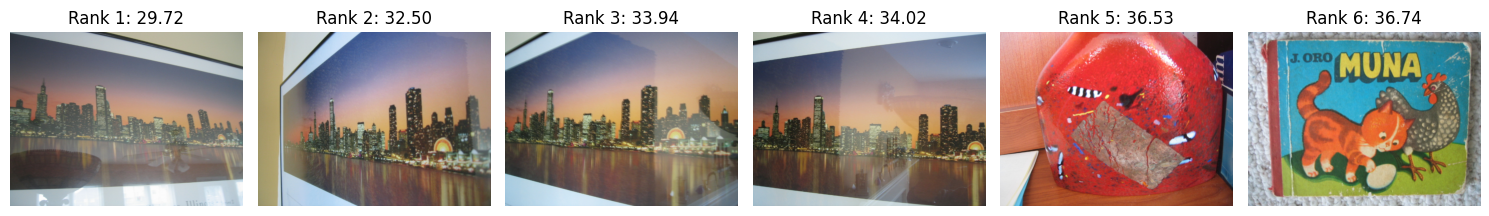

In [80]:
# Compute the feature histograms for the test images
sift = cv2.SIFT_create()
image_features = compute_feature_histograms(train_image_paths, voc, sift, k)

# Use the search engine
query_image_path = '/content/Data-BoW/dataset-retr/train/ukbench00038.jpg'

# Perform the search
top_n = 6
similar_images = search_similar_images(query_image_path, train_image_paths, voc, sift, stdSlr, k, top_n)

# Display the original image
plt.figure(figsize=(6, 6))
query_image = cv2.imread(query_image_path)
query_image_rgb = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image_rgb)

# Create a figure and subplots for displaying the images
fig, axes = plt.subplots(1, top_n, figsize=(15, 5))  # Adjust the figure size as needed

# Loop through the top n similar images and display them in the subplots
for idx, (image_path, distance) in enumerate(similar_images):
    print(f"Rank {idx + 1}: {image_path} with similarity score (distance): {distance}")

    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image in the corresponding subplot
    axes[idx].imshow(image_rgb)
    axes[idx].axis('off')  # Hide axes for cleaner display
    axes[idx].set_title(f"Rank {idx + 1}: {distance:.2f}")  # Set the title with the rank and similarity score

# Show the plot with all subplots
plt.tight_layout()
plt.show()

**Exercice 2:**

Now, use Convolutional Neural Network (CNN) as descriptors instead of SIFT keypoints and BoW for your search engine. Use a pretarined model like VGG16 for cnn feature extracing.

Rank 1: ./Data-BoW/dataset-retr/train/ukbench00000.jpg with similarity score (distance): 0.0
Rank 2: ./Data-BoW/dataset-retr/train/ukbench00003.jpg with similarity score (distance): 1100.1758876637334
Rank 3: ./Data-BoW/dataset-retr/train/ukbench00001.jpg with similarity score (distance): 1228.276093657514
Rank 4: ./Data-BoW/dataset-retr/train/ukbench00002.jpg with similarity score (distance): 1251.9896823930205
Rank 5: ./Data-BoW/dataset-retr/train/ukbench00040.jpg with similarity score (distance): 1317.75646466421
Rank 6: ./Data-BoW/dataset-retr/train/ukbench00038.jpg with similarity score (distance): 1320.1920621120148


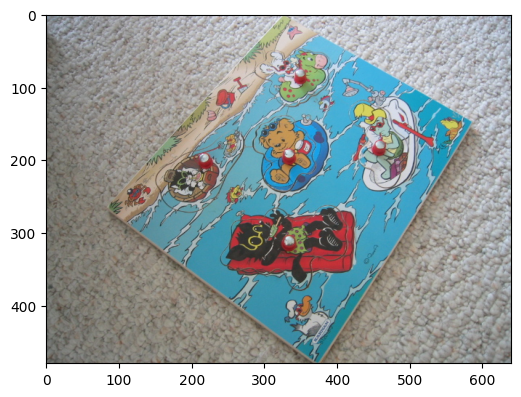

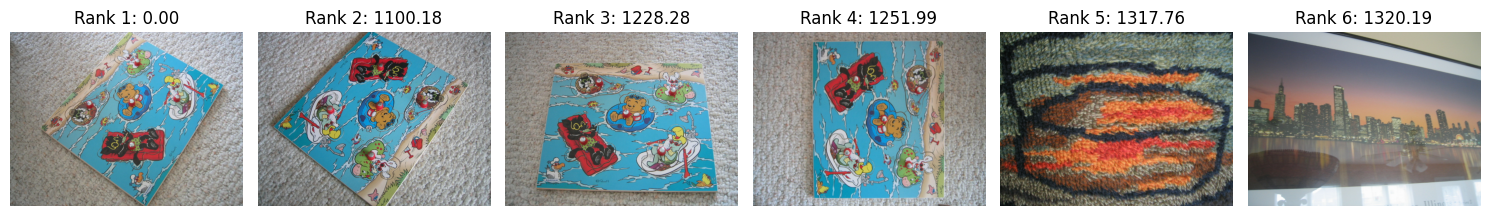

In [81]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the features from the last convolutional block
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load and preprocess images for VGG16
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to 224x224 for VGG16 input
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = preprocess_input(image)  # Preprocess for VGG16
    return image

# Function to extract CNN features from an image
def extract_cnn_features(image_path, model):
    image = preprocess_image(image_path)
    features = model.predict(image, verbose=0)
    features = features.flatten()  # Flatten the feature map
    return features

# Function to compute the similarity (using Euclidean distance or cosine similarity)
def compute_similarity(query_features, image_features, metric='euclidean'):
    if metric == 'euclidean':
        return cdist(query_features, image_features, metric='euclidean')
    elif metric == 'cosine':
        return cdist(query_features, image_features, metric='cosine')

# Load the model and the feature database
image_paths = train_image_paths

# Extract CNN features for all images in the database
image_features = []
for image_path in image_paths:
    features = extract_cnn_features(image_path, model)
    image_features.append(features)

# Convert image_features list to a numpy array for easier manipulation
image_features = np.array(image_features)

# Extract CNN features for all images in the database
image_features = []
for image_path in image_paths:
    features = extract_cnn_features(image_path, model)
    image_features.append(features)

# Convert image_features list to a numpy array for easier manipulation
image_features = np.array(image_features)

# Query Image
query_image_path = '/content/Data-BoW/dataset-retr/train/ukbench00000.jpg'

# Extract CNN features for the query image
query_features = extract_cnn_features(query_image_path, model)

# Compute the similarity between the query image and the database images
similarity_scores = compute_similarity(query_features.reshape(1, -1), image_features, metric='euclidean')

# Perform the search
top_n = 6
sorted_indices = np.argsort(similarity_scores.flatten())[:top_n]

# Display the original image
plt.figure(figsize=(6, 6))
query_image = cv2.imread(query_image_path)
query_image_rgb = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.imshow(query_image_rgb)

# Create a figure and subplots for displaying the images
fig, axes = plt.subplots(1, top_n, figsize=(15, 5))  # Adjust the figure size as needed

# Loop through the top n similar images and display them in the subplots
for i, idx in enumerate(sorted_indices):  # Use 'i' to index into axes
    similar_image_path = image_paths[idx]
    print(f"Rank {i + 1}: {similar_image_path} with similarity score (distance): {similarity_scores[0][idx]}")

    # Read and display the similar image
    similar_image = cv2.imread(similar_image_path)
    similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

    # Display the image in the corresponding subplot
    axes[i].imshow(similar_image_rgb)  # Use 'i' to index into axes
    axes[i].axis('off')  # Hide axes for cleaner display
    axes[i].set_title(f"Rank {i + 1}: {similarity_scores[0][idx]:.2f}")

# Show the plot with all subplots
plt.tight_layout()
plt.show()
